# Gaia photometric time series

In this notebook we use `astroquery` to get lists of stars classified as variables in the Gaia archive, grab their photometric time series (the measured luminosity at multiple times), and fold their light curves.

In [1]:
from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = -1

import matplotlib.pyplot as plt
import numpy as np

The following query gets a short list of bright stars for which photometric time series are available, a variable class is provided in the `gaiadr3.vari_classifier_result` table, and with a large number of transits.

In [2]:
%%time
query_string = """select TOP 5 gg.l, gg.b, gg.source_id, gg.phot_g_mean_mag as g, gg.bp_rp, vv.best_class_name
from gaiadr3.gaia_source as gg, gaiadr3.vari_classifier_result as vv
WHERE gg.source_id = vv.source_id
AND gg.has_epoch_photometry = 't' and gg.phot_g_mean_mag<13 and gg.astrometric_matched_transits>100"""

job = Gaia.launch_job_async(query_string,
                    dump_to_file=False, output_format='votable')
GaiaT = job.get_results()
GaiaT

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 499 ms, sys: 35 ms, total: 534 ms
Wall time: 7.21 s


l,b,source_id,g,bp_rp,best_class_name
deg,deg,,mag,mag,
float64,float64,int64,float32,float32,object
325.6922784110518,-13.192117665315699,5817537089397173120,12.850792,0.8849058,SOLAR_LIKE
325.74381091953165,-13.032721337533308,5817542037199601408,12.726269,0.8961134,SOLAR_LIKE
325.6350920618631,-12.799039201304138,5817556537009685888,11.47946,0.7877846,ECL
325.6962649981643,-12.797053303629376,5817558220636873216,11.7664795,0.5977993,DSCT|GDOR|SXPHE
325.72987510347514,-12.762413818496864,5817558736037738240,12.9009285,2.2182379,LPV


Quick hack to find out class given a list of source_id:

In [3]:
%%time
query_string = """select * from gaiadr3.vari_classifier_result
where source_id in ('""" + "','".join([str(sss) for sss in GaiaT['source_id']]) + "')"

job = Gaia.launch_job_async(query_string,
                    dump_to_file=False, output_format='votable')
variT = job.get_results()
variT

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 104 ms, sys: 5.75 ms, total: 110 ms
Wall time: 615 ms


solution_id,source_id,classifier_name,best_class_name,best_class_score
int64,int64,object,object,float32
375316653866487564,5817537089397173120,nTransits:5+,SOLAR_LIKE,0.6289267
375316653866487564,5817542037199601408,nTransits:5+,SOLAR_LIKE,0.047377717
375316653866487564,5817556537009685888,nTransits:5+,ECL,0.8862629
375316653866487564,5817558220636873216,nTransits:5+,DSCT|GDOR|SXPHE,0.86623335
375316653866487564,5817558736037738240,nTransits:5+,LPV,0.7403101


We can retrieve the epoch photometry for each source, but be careful if you pass a list of `source_id`, **the datalink product might be in a different order!**

In this example we only look at epoch photometry, but you can use this interface to retrieve other products that are not directly provided through ADQL queries.

In [4]:
retrieval_type = 'EPOCH_PHOTOMETRY'          
# Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'

data_structure = 'INDIVIDUAL'     
# Options are: 'INDIVIDUAL' or 'RAW'

data_release   = 'Gaia DR3'   
# Options are: 'Gaia DR3' (default), 'Gaia DR2'

datalink = Gaia.load_data(ids=GaiaT['source_id'],
                          data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure)

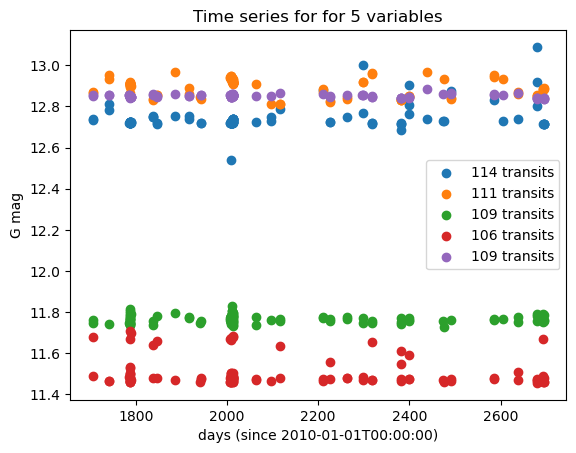

In [5]:
# Plot the time series:
for iii,source in enumerate(datalink.values()):
    source_table = source[0].to_table()
    plt.scatter(source_table['g_transit_time'], 
                source_table['g_transit_mag'],
                label='%i transits' % (len(source_table)))
plt.title('Time series for for 5 variables')
plt.xlabel('days (since 2010-01-01T00:00:00)'); plt.ylabel('G mag'); plt.legend();

## RR Lyrae

Here we query specifically sources that are in BOTH the main Gaia table and the RR Lyrae table.

In [6]:
%%time
query_string = """select TOP 5 gg.l, gg.b, gg.source_id, gg.phot_g_mean_mag as g, gg.bp_rp, rr.pf, rr.pf_error
from gaiadr3.gaia_source as gg, gaiadr3.vari_rrlyrae as rr
WHERE gg.source_id = rr.source_id
AND gg.has_epoch_photometry = 't' 
AND gg.phot_g_mean_mag<15
AND gg.astrometric_matched_transits>120"""

job = Gaia.launch_job_async(query_string,
                    dump_to_file=False, output_format='votable')
rrT = job.get_results()
rrT

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 561 ms, sys: 22.8 ms, total: 583 ms
Wall time: 10.2 s


l,b,source_id,g,bp_rp,pf,pf_error
deg,deg,,mag,mag,d,d
float64,float64,int64,float32,float32,float64,float32
224.5190094938927,-59.18704269989191,5059364001725327232,13.121175,0.58667374,0.5535722081618433,2.9021603e-06
79.45780726648066,-12.411919970381113,1853751148171392256,11.547016,0.6910391,0.4198623093455614,8.8308167e-07
315.6478409926224,-4.339642215582809,5873869674341572480,13.957066,1.2103577,0.4725015078770734,1.7027503e-06
304.9151056276028,5.860583175890597,6066373303970045056,13.044055,0.853796,0.36114371451664085,1.3010886e-06
289.9521185946019,-74.52900695093193,4984655725669340544,12.770992,0.62323856,0.6156013117913836,1.1953981e-06


We query the datalink individually for each star, this would be inefficient for a million stars but here we only have five.

Since the Gaia archive also provides the period for each RR Lyrae, we can display the folded light curve by using `time % period` on the x-axis.

0 EPOCH_PHOTOMETRY-Gaia DR3 5059364001725327232.xml
1 EPOCH_PHOTOMETRY-Gaia DR3 1853751148171392256.xml
2 EPOCH_PHOTOMETRY-Gaia DR3 5873869674341572480.xml
3 EPOCH_PHOTOMETRY-Gaia DR3 6066373303970045056.xml
4 EPOCH_PHOTOMETRY-Gaia DR3 4984655725669340544.xml


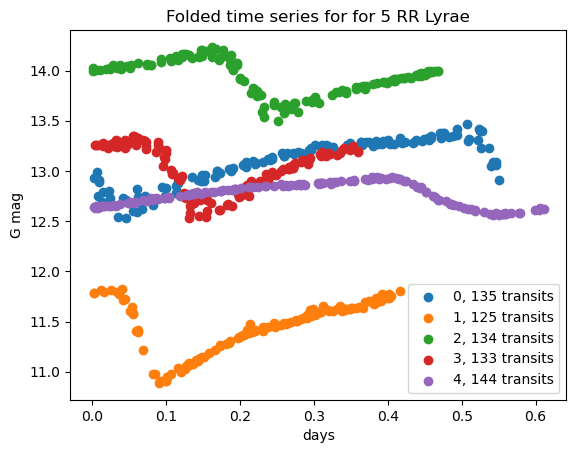

In [7]:
# Query the time series for each source individually, so we are sure they are in the right order:
for iii,source in enumerate(rrT['source_id']):
    datalink = Gaia.load_data(ids=[source],
                          data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure)
    source_table = list(datalink.values())[0][0].to_table()
    plt.scatter(source_table['g_transit_time'] % rrT['pf'][iii], 
                source_table['g_transit_mag'],
                label='%i, %i transits' % (iii,len(source_table)))
    print(iii,list(datalink.keys())[0])
plt.xlabel('days'); plt.ylabel('G mag'); plt.legend()
plt.title('Folded time series for for 5 RR Lyrae');

## Looking at one specific star: w Crt

This is a bright RR Lyrae: https://simbad.u-strasbg.fr/simbad/sim-id?Ident=w+crt

Text(0.5, 1.0, 'w Crt time series')

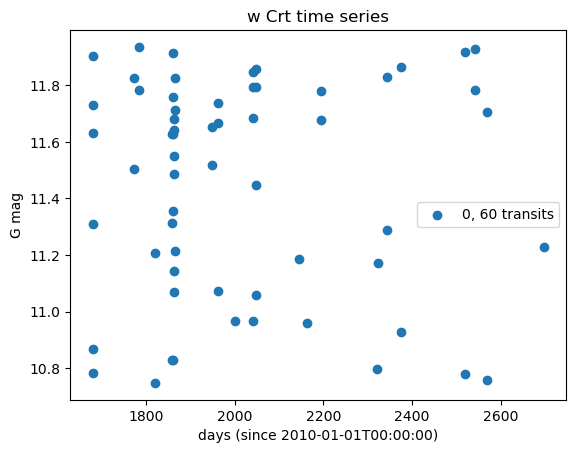

In [8]:
datalink = Gaia.load_data(ids='3546458301374134528',
                          data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure)
for iii,source in enumerate(datalink.values()):
    source_table = source[0].to_table()
    plt.scatter(source_table['g_transit_time'], 
                source_table['g_transit_mag'],
                label='%i, %i transits' % (iii,len(source_table)))
plt.xlabel('days (since 2010-01-01T00:00:00)'); plt.ylabel('G mag'); plt.legend();
plt.title('w Crt time series')

If we know the variation period, we can *fold* the light curve and see the 60 measurements at 60 different moments in the pattern. But even a tiny mistake in the estimated period can result in a very noisy folded light curve:

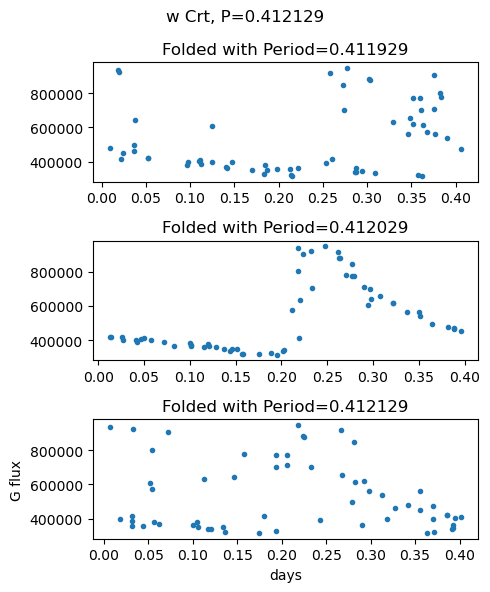

In [9]:
delta = 0.0001
period = 0.4120288

plt.figure(figsize=(5,6))
for iii,ppp in enumerate([period-delta,period,period+delta]):
    plt.subplot(3,1,iii+1)
    plt.errorbar(source_table['g_transit_time'] % ppp, 
                source_table['g_transit_flux'],
                yerr=source_table['g_transit_flux_error'], fmt='.')
    plt.title('Folded with Period=%f' % ppp)
    
plt.xlabel('days'); plt.ylabel('G flux')
plt.suptitle('w Crt, P=%f' % (ppp))
plt.tight_layout()

## Trying the Lomb-Scargle periodogram 

(this is tough here because of the sparse sampling).

In [10]:
from astropy.timeseries import LombScargle

In [11]:
frequency, power = LombScargle(source_table['g_transit_time'],
                               source_table['g_transit_flux'], 
                               dy=source_table['g_transit_flux_error']).autopower()
print(frequency[np.argmax(power)])

0.12482457378818186 1 / d


0.40330340000153275 1 / d


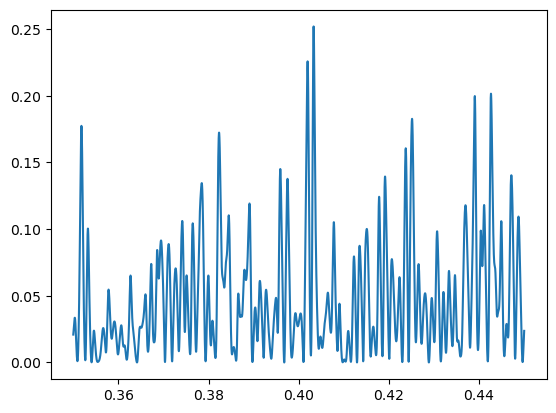

In [12]:
# Compute the Lomb-Scargle periodogram at a user-specified frequency grid:
from astropy import units as u
#freq = np.arange(period-10*delta,period+10*delta, 0.0000001) / u.d
freq = np.arange(0.35,0.45, 0.0000001) / u.d

powers = LombScargle(source_table['g_transit_time'], 
                     source_table['g_transit_flux'],
                     dy=source_table['g_transit_flux_error']).power(freq)  

plt.plot( freq , powers )
print(freq[np.argmax(powers)])